In [54]:
import pandas as pd
import numpy as np
# import ydata_profiling
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
from math import pi
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
import json
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

In [55]:
%%time
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}   

# data set load
DATA_PATH = '/opt/ml/input/data'
train_path = os.path.join(DATA_PATH, 'train_data.csv')
test_path = os.path.join(DATA_PATH, 'test_data.csv')

train_df = pd.read_csv(train_path, dtype=dtype, parse_dates=['Timestamp'])
test_df = pd.read_csv(test_path, dtype=dtype, parse_dates=['Timestamp'])

diff_train = train_df.loc[:, ['userID', 'Timestamp']].groupby('userID').diff().shift(-1)

# total_seconds(): 모든 속성을 초단위로 모아서 변환
diff_train = diff_train['Timestamp'].apply(lambda x: x.total_seconds())

train_df['elapsed'] = diff_train


diff_test = test_df.loc[:, ['userID', 'Timestamp']].groupby('userID').diff().shift(-1)

# total_seconds(): 모든 속성을 초단위로 모아서 변환
diff_test = diff_test['Timestamp'].apply(lambda x: x.total_seconds())

test_df['elapsed'] = diff_test
test_df = test_df[test_df['answerCode'] != -1]
test_df = test_df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)


df = pd.concat([train_df, test_df])
# df = df.drop(df[df['answerCode']== -1].index) # answerCode = -1 는 예측해야하는 값이므로 제외'Affine

import pytz
kst = pytz.timezone('Asia/Seoul')
df['Timestamp'] = df['Timestamp'].dt.tz_localize('UTC').dt.tz_convert(kst)

CPU times: user 9.16 s, sys: 508 ms, total: 9.67 s
Wall time: 9.67 s


# 시간 추가 전처리

In [ ]:
def percentile(s):
    return np.sum(s) / len(s)

In [ ]:
diff = df.loc[:, ['userID', 'Timestamp']].groupby('userID').diff().fillna(pd.Timedelta(seconds=0))
diff = diff.fillna(pd.Timedelta(seconds=0))
diff = diff['Timestamp'].apply(lambda x: x.total_seconds())

df['elapsed'] = diff

In [ ]:
df['elapsed'] = df['elapsed'].shift(-1, axis=0)

# testcode 전처리

In [ ]:
df['testcode'] = df['testId'].apply(lambda x: x[1:4])

# 유저 별 정답률 분석

In [ ]:
stu_groupby = df.groupby('userID').agg({
    'assessmentItemID': 'count',
    'answerCode': percentile
})
stu_groupby.describe()

,assessmentItemID,answerCode
count,6698.000000,6698.000000
mean,338.397432,0.628909
std,321.331429,0.159639
min,9.000000,0.000000
25%,78.000000,0.527273
50%,231.500000,0.651757
75%,513.000000,0.751203
max,1860.000000,1.000000


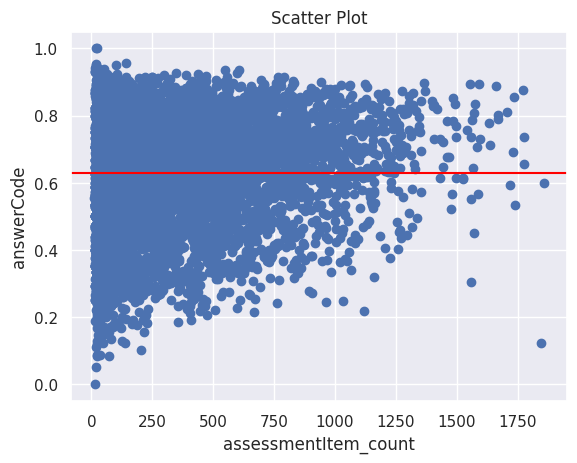

In [ ]:
plt.scatter(stu_groupby['assessmentItemID'], stu_groupby['answerCode'])
plt.axhline(stu_groupby['answerCode'].mean(), color='red')
plt.xlabel('assessmentItem_count')
plt.ylabel('answerCode')
plt.title('Scatter Plot')
plt.show()

## 누구냐 만점자 2명!

In [ ]:
stu_groupby[stu_groupby['answerCode'] == 1]

,assessmentItemID,answerCode
userID,,
6988,23,1.0
7171,20,1.0


In [ ]:
df[df['userID']==6988]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
2257763,6988,A080002001,A080000002,1,2020-01-20 06:00:04,4605,2.0
2257764,6988,A080002002,A080000002,1,2020-01-20 06:00:06,1394,4.0
2257765,6988,A080002003,A080000002,1,2020-01-20 06:00:10,1396,8.0
2257766,6988,A080002004,A080000002,1,2020-01-20 06:00:18,1397,5.0
2257767,6988,A080002005,A080000002,1,2020-01-20 06:00:23,1396,3.0
2257768,6988,A080002006,A080000002,1,2020-01-20 06:00:26,1395,18996168.0
2257769,6988,A050181001,A050000181,1,2020-08-27 02:43:14,10397,214.0
2257770,6988,A050181002,A050000181,1,2020-08-27 02:46:48,10397,181.0
2257771,6988,A050181003,A050000181,1,2020-08-27 02:49:49,10397,153.0
2257772,6988,A050181004,A050000181,1,2020-08-27 02:52:22,10397,33.0


In [ ]:
df[df['userID']==7171]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
2261914,7171,A060183001,A060000183,1,2020-08-11 10:15:05,1576,22.0
2261915,7171,A060183002,A060000183,1,2020-08-11 10:15:27,1575,5.0
2261916,7171,A060183003,A060000183,1,2020-08-11 10:15:32,1576,101.0
2261917,7171,A060183004,A060000183,1,2020-08-11 10:17:13,1575,115.0
2261918,7171,A060183005,A060000183,1,2020-08-11 10:19:08,1576,1787424.0
2261919,7171,A060185001,A060000185,1,2020-09-01 02:49:32,1580,25.0
2261920,7171,A060185002,A060000185,1,2020-09-01 02:49:57,1581,232.0
2261921,7171,A060185003,A060000185,1,2020-09-01 02:53:49,1581,33.0
2261922,7171,A060185004,A060000185,1,2020-09-01 02:54:22,1581,43.0
2261923,7171,A060185005,A060000185,1,2020-09-01 02:55:05,1581,3836835.0


만점자에게 특별한 점은 없지만 이상치로 보고 제거?

## 0점인 학생은?

In [ ]:
stu_groupby[stu_groupby['answerCode'] == 0]

,assessmentItemID,answerCode
userID,,
7166,16,0.0


In [ ]:
df[df['userID']==7166]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
2261803,7166,A030126001,A030000126,0,2020-07-30 22:46:27,574,95.0
2261804,7166,A030126002,A030000126,0,2020-07-30 22:48:02,574,77.0
2261805,7166,A030126003,A030000126,0,2020-07-30 22:49:19,574,10.0
2261806,7166,A030126004,A030000126,0,2020-07-30 22:49:29,574,4.0
2261807,7166,A030126005,A030000126,0,2020-07-30 22:49:33,574,4689767.0
2261808,7166,A010163001,A010000163,0,2020-09-23 05:32:20,7809,9.0
2261809,7166,A010163002,A010000163,0,2020-09-23 05:32:29,7809,3.0
2261810,7166,A010163003,A010000163,0,2020-09-23 05:32:32,7809,1.0
2261811,7166,A010163004,A010000163,0,2020-09-23 05:32:33,7809,5.0
2261812,7166,A010163005,A010000163,0,2020-09-23 05:32:38,7809,7599276.0


1명 뿐이고 찍은 느낌을 주는 Test 도 발견 이상치 제거

## 이상치 분석

많은 문제를 풀었지만 정답률이 낮은 학생 2명 분석

In [ ]:
stu_groupby.loc[481:482]

,assessmentItemID,answerCode
userID,,
481,1847,0.124526


In [ ]:
outlier_id1 = df[df['userID'] == 481]
outlier_id1.describe()

,userID,answerCode,Timestamp,KnowledgeTag,elapsed
count,1847.0,1847.000000,1847,1847.000000,1.847000e+03
mean,481.0,0.124526,2020-08-14 00:54:57.155928320,4215.559827,1.417264e+04
min,481.0,0.000000,2020-03-01 02:47:37,116.000000,0.000000e+00
25%,481.0,0.000000,2020-06-28 21:39:39,705.000000,2.000000e+00
50%,481.0,0.000000,2020-08-20 07:32:51,1548.000000,3.000000e+00
75%,481.0,0.000000,2020-10-06 05:14:00,8005.000000,1.400000e+01
max,481.0,1.000000,2020-12-29 02:08:48,10838.000000,3.790402e+06
std,0.0,0.330270,NaN,3805.340085,1.262338e+05


In [ ]:
stu_groupby.iloc[520:521]

,assessmentItemID,answerCode
userID,,
585,1557,0.303789


In [ ]:
outlier_id2 = df[df['userID'] == 585]
outlier_id2.describe()

,userID,answerCode,Timestamp,KnowledgeTag,elapsed
count,1557.0,1557.000000,1557,1557.000000,1557.000000
mean,585.0,0.303789,2020-07-27 00:51:58.374438144,5016.434168,15234.432241
min,585.0,0.000000,2020-03-06 13:27:00,23.000000,0.000000
25%,585.0,0.000000,2020-06-14 14:21:32,2718.000000,2.000000
50%,585.0,0.000000,2020-07-20 02:25:25,4804.000000,4.000000
75%,585.0,1.000000,2020-09-19 01:35:28,7924.000000,38.000000
max,585.0,1.000000,2020-12-06 02:20:31,10573.000000,521979.000000
std,0.0,0.460041,NaN,2768.826353,58629.965562


In [ ]:
outlier_id1[outlier_id1['elapsed']>650]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
354412,481,A070001009,A070000001,1,2020-03-01 02:54:47,116,2055475.0
354421,481,A070005008,A070000005,0,2020-03-24 21:53:21,3794,75197.0
354430,481,A070007009,A070000007,0,2020-03-25 18:46:55,607,459694.0
354438,481,A070009009,A070000009,0,2020-03-31 02:29:23,3795,59506.0
354447,481,A070011008,A070000011,1,2020-03-31 19:01:26,3820,172493.0
...,...,...,...,...,...,...,...
356203,481,A070111008,A070000111,0,2020-11-05 01:57:39,9660,170860.0
356209,481,A070112005,A070000112,1,2020-11-07 01:25:49,9660,3790402.0
356217,481,A070129006,A070000129,0,2020-12-20 22:20:14,9065,7014.0
356225,481,A070127008,A070000127,0,2020-12-21 00:17:41,9066,5270.0


In [ ]:
outlier_id1[outlier_id1['elapsed']>650].testId.nunique()

97

In [ ]:
outlier_id1[outlier_id1['elapsed']>650].loc[:,'elapsed'] = 650

In [ ]:
# 문제 풀이 시간이 너무 큰 경우 650으로 변경
outlier_id1['elapsed'] = outlier_id1['elapsed'].apply(lambda x: 650 if x > 650 else x)

/tmp/ipykernel_9910/1995579594.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_id1['elapsed'] = outlier_id1['elapsed'].apply(lambda x: 650 if x > 650 else x)


# 문제 별 정답률 분석

In [ ]:
prob_groupby = df.groupby('assessmentItemID').agg({
    'userID': 'count',
    'answerCode': percentile
})
prob_groupby.describe()

,userID,answerCode
count,9454.000000,9454.000000
mean,239.748889,0.654256
std,71.893791,0.195488
min,43.000000,0.049430
25%,220.000000,0.505548
50%,230.000000,0.666667
75%,271.000000,0.820513
max,454.000000,0.996310


In [ ]:
prob_groupby.corr()

,userID,answerCode
userID,1.000000,0.002082
answerCode,0.002082,1.000000


In [ ]:
pro_mean = prob_groupby['answerCode'].mean()

In [ ]:
pro_high = prob_groupby[prob_groupby['answerCode']>=pro_mean]
pro_low = prob_groupby[prob_groupby['answerCode']<pro_mean]

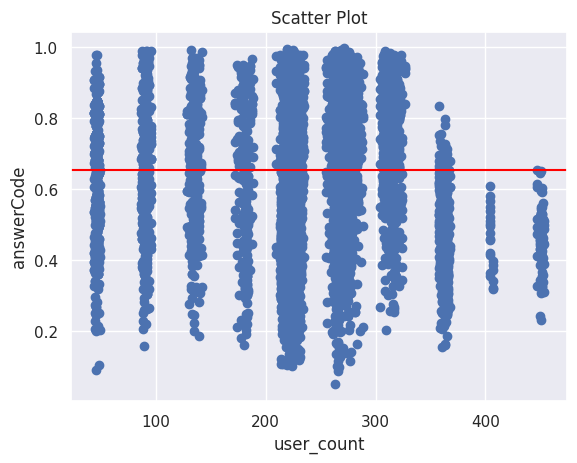

In [ ]:
plt.scatter(prob_groupby['userID'], prob_groupby['answerCode'])
plt.axhline(prob_groupby['answerCode'].mean(), color='red')
plt.xlabel('user_count')
plt.ylabel('answerCode')
plt.title('Scatter Plot')
plt.show()

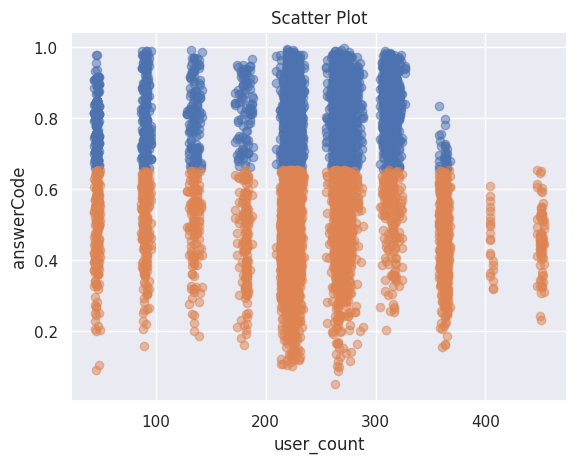

In [ ]:
plt.scatter(pro_high['userID'], pro_high['answerCode'], alpha=0.5)
plt.scatter(pro_low['userID'], pro_low['answerCode'], alpha=0.5)
plt.xlabel('user_count')
plt.ylabel('answerCode')
plt.title('Scatter Plot')
plt.show()

- 350명 이하의 유저가 푼 문제들은 대체로 정답률이 골고루 분포함
- 350명 이상이 푼 문제의 정답률의 범위가 줄어듬

In [ ]:
prob_groupby[prob_groupby['answerCode'] < 0.2]

,userID,answerCode
assessmentItemID,,
A010136005,177,0.180791
A020020005,260,0.196154
A020103005,266,0.086466
A020168005,139,0.187050
A020173005,283,0.162544
...,...,...
A080099003,363,0.162534
A080101003,363,0.159780
A080129006,361,0.155125


## 이상치 문제? 보기

In [ ]:
prob_groupby.loc[(prob_groupby['answerCode'] <= 0.2) & (prob_groupby['userID'] <= 100)]

,userID,answerCode
assessmentItemID,,
A070162008,89,0.157303
A090002004,48,0.104167
A090071004,45,0.088889
A090071006,45,0.200000


In [ ]:
df[df['assessmentItemID']== 'A090071004']

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
1655,1,A090071004,A090000071,0,2020-11-04 02:18:53,9929,211.0
74884,97,A090071004,A090000071,0,2020-12-13 10:14:15,9929,18.0
128536,165,A090071004,A090000071,0,2020-12-17 23:20:41,9929,3.0
289939,393,A090071004,A090000071,0,2020-12-11 07:01:02,9929,1.0
331845,447,A090071004,A090000071,0,2020-11-21 02:08:27,9929,2.0
396972,543,A090071004,A090000071,0,2020-12-03 04:50:51,9929,4.0
409208,567,A090071004,A090000071,0,2020-11-13 00:07:03,9929,1.0
424943,592,A090071004,A090000071,0,2020-12-09 05:20:36,9929,2.0
520725,729,A090071004,A090000071,1,2020-11-13 05:51:54,9929,1334.0
536940,751,A090071004,A090000071,0,2020-12-01 03:29:44,9929,5.0


In [ ]:
df.iloc[1769280:1769292]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
1769280,3260,A090069003,A090000069,1,2020-12-08 01:20:50,2644,159.0
1769281,3260,A090069004,A090000069,1,2020-12-08 01:23:29,9924,11.0
1769282,3260,A090069005,A090000069,1,2020-12-08 01:23:40,2644,56.0
1769283,3260,A090069006,A090000069,1,2020-12-08 01:24:36,9924,620713.0
1769284,3260,A090071001,A090000071,1,2020-12-15 05:49:49,2644,85.0
1769285,3260,A090071002,A090000071,1,2020-12-15 05:51:14,9924,174.0
1769286,3260,A090071003,A090000071,1,2020-12-15 05:54:08,9924,326.0
1769287,3260,A090071004,A090000071,1,2020-12-15 05:59:34,9929,90.0
1769288,3260,A090071005,A090000071,1,2020-12-15 06:01:04,2647,7.0
1769289,3260,A090071006,A090000071,0,2020-12-15 06:01:11,2647,3.0


- 어려운 문제를 맞은 유저들은 약간의 긴 시간을 투자하고 틀린 유저들은 대체로 짧은 시간을 투자함

## 가장 어려운 문제 분석

In [ ]:
# 정답률이 가장 낮은 문제
prob_groupby[prob_groupby['answerCode'] <= 0.049431]

,userID,answerCode
assessmentItemID,,
A040131005,263,0.04943


In [ ]:
hard_pro = df[df['assessmentItemID']== 'A040131005']
hard_pro[hard_pro['answerCode'] == 1]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
39300,51,A040131005,A040000131,1,2020-07-28 09:06:24,10615,80877.0
106414,137,A040131005,A040000131,1,2020-09-18 03:18:35,10615,259021.0
134400,174,A040131005,A040000131,1,2020-02-01 03:00:01,10615,1852.0
377936,515,A040131005,A040000131,1,2020-09-27 02:22:34,10615,90.0
498412,700,A040131005,A040000131,1,2020-09-11 06:40:44,10615,150284.0
921840,1365,A040131005,A040000131,1,2020-09-08 02:57:14,10615,101668.0
1001742,1497,A040131005,A040000131,1,2020-06-26 12:35:28,10615,69456.0
1445015,2403,A040131005,A040000131,1,2020-10-08 10:25:12,10615,119.0
1538834,2635,A040131005,A040000131,1,2020-10-06 05:30:15,10615,122787.0
1682236,2997,A040131005,A040000131,1,2020-09-24 07:19:11,10615,59251.0


In [ ]:
hard_pro[hard_pro['answerCode'] == 1].elapsed.mean(), hard_pro[hard_pro['answerCode'] == 0].elapsed.mean()

(84975.46153846153, 203087.86)

In [ ]:
elapsed_answer = hard_pro.groupby('elapsed').agg({'answerCode': percentile, 'userID': 'count'})

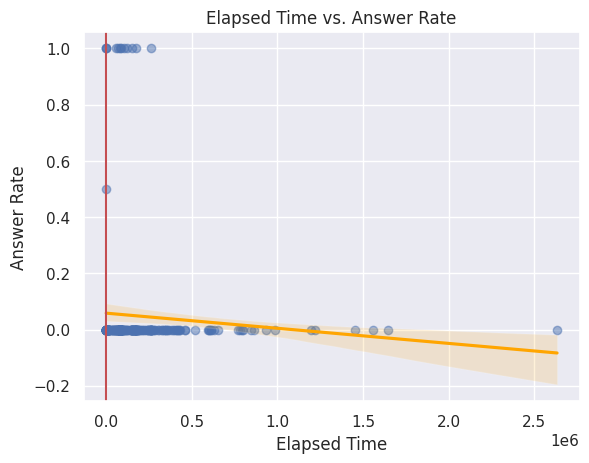

In [ ]:
fig, ax = plt.subplots()
g = sns.regplot(x=elapsed_answer.index[:-1], y=elapsed_answer.answerCode.values[:-1],
            scatter_kws={'alpha':0.5}, line_kws={"color": "orange"}, ax=ax)
ax.set_title('Elapsed Time vs. Answer Rate')
ax.set_xlabel('Elapsed Time')
ax.set_ylabel('Answer Rate')
ax.axvline(22, color='r')
# ax.set_xlim(-10, 650)

In [ ]:
smart_peo = hard_pro[hard_pro['answerCode'] == 1].userID.unique()
stu_groupby.loc[smart_peo, :]

,assessmentItemID,answerCode
userID,,
51,1662,0.888688
137,398,0.552764
174,1525,0.615082
515,830,0.724096
700,538,0.828996
1365,529,0.773157
1497,775,0.659355
2403,579,0.739206
2635,540,0.696296


In [ ]:
df.loc[(df.userID == 3640) & (df.testId == 'A040000131')]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
1874503,3640,A040131001,A040000131,1,2020-09-17 09:44:18,2102,19.0
1874504,3640,A040131002,A040000131,1,2020-09-17 09:44:37,10615,13.0
1874505,3640,A040131003,A040000131,1,2020-09-17 09:44:50,2102,13.0
1874506,3640,A040131004,A040000131,0,2020-09-17 09:45:03,2102,68.0
1874507,3640,A040131005,A040000131,1,2020-09-17 09:46:11,10615,64.0


- 어려운 문제의 경우는 찍어서 맞추는 유저가 없어 보임
- 맞춘 유저의 평균 시간이 틀린 유저의 평균 시간보다 작다

## 51번 학생 넌 누구냐?

- 많은 문제를 풀고 정답률도 높은 학생

In [ ]:
user51 = df[df['userID']==51]
user51.describe()

,userID,answerCode,Timestamp,KnowledgeTag,elapsed
count,1662.0,1662.000000,1662,1662.000000,1662.000000
mean,51.0,0.888688,2020-06-11 01:17:49.356798976,3920.290614,17405.469916
min,51.0,0.000000,2020-01-02 11:13:33,23.000000,0.000000
25%,51.0,1.000000,2020-03-23 18:34:25.249999872,2077.250000,36.000000
50%,51.0,1.000000,2020-06-04 11:38:58.500000,3691.000000,80.000000
75%,51.0,1.000000,2020-08-27 10:11:41.249999872,4974.000000,284.500000
max,51.0,1.000000,2020-12-02 06:45:04,11271.000000,629485.000000
std,0.0,0.314612,NaN,2598.554850,55454.079949


In [ ]:
user51.testcode.unique()

array(['040', '080', '050'], dtype=object)

In [ ]:
user51[user51['answerCode']==0]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed,testcode
38265,51,A040010002,A040000010,0,2020-01-09 11:36:29,2048,208.0,040
38268,51,A040010005,A040000010,0,2020-01-09 11:50:15,2047,168.0,040
38274,51,A040011005,A040000011,0,2020-01-10 04:11:12,2049,31.0,040
38292,51,A040012005,A040000012,0,2020-01-14 11:31:19,2050,92.0,040
38293,51,A040012006,A040000012,0,2020-01-14 11:32:51,2050,110915.0,040
...,...,...,...,...,...,...,...,...
39748,51,A040150003,A040000150,0,2020-10-23 11:09:50,2115,83.0,040
39753,51,A080129003,A080000129,0,2020-10-23 16:23:45,2725,70.0,080
39756,51,A080129006,A080000129,0,2020-10-23 16:29:18,2725,228139.0,080
39855,51,A080102004,A080000102,0,2020-11-24 01:28:17,7170,63.0,080


- 4, 5, 8 testcode를 풀었다
- 틀린 문제도 찍은게 아니라 시간을 투자했지만 틀림
- 평균 시간이 높음

## 시간 관련 이상치 발견?

In [ ]:
df[df['assessmentItemID']== 'A090002004']

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed,testcode
127543,165,A090002004,A090000002,0,2020-02-20 02:49:57,4697,1.0,090
226797,306,A090002004,A090000002,0,2020-06-21 07:18:03,4697,347.0,090
264389,358,A090002004,A090000002,0,2020-03-04 02:33:30,4697,5.0,090
268381,365,A090002004,A090000002,0,2020-04-11 04:59:42,4697,74.0,090
347254,467,A090002004,A090000002,0,2020-02-27 04:14:49,4697,8.0,090
509570,718,A090002004,A090000002,0,2020-05-03 06:08:54,4697,77.0,090
519742,729,A090002004,A090000002,0,2020-05-08 01:50:36,4697,13.0,090
536377,751,A090002004,A090000002,0,2020-04-11 03:58:35,4697,5.0,090
575661,813,A090002004,A090000002,0,2020-05-13 03:10:35,4697,50.0,090
607615,863,A090002004,A090000002,0,2020-04-08 20:23:46,4697,80.0,090


In [ ]:
# 어려운 문제를 적은 시간에 맞춘 유저 분석
df[df['userID']== 2900]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed,testcode
1643848,2900,A020028001,A020000028,1,2020-04-02 09:06:50,7913,72.0,020
1643849,2900,A020028002,A020000028,1,2020-04-02 09:08:02,7913,16.0,020
1643850,2900,A020028003,A020000028,1,2020-04-02 09:08:18,7913,33.0,020
1643851,2900,A020028004,A020000028,1,2020-04-02 09:08:51,7913,53.0,020
1643852,2900,A020028005,A020000028,1,2020-04-02 09:09:44,7913,1189555.0,020
...,...,...,...,...,...,...,...,...
1644461,2900,A090037007,A090000037,1,2020-12-29 03:55:28,9852,9.0,090
1644462,2900,A090037001,A090000037,0,2020-12-29 03:55:37,1249,2.0,090
1644463,2900,A090037002,A090000037,0,2020-12-29 03:55:39,1249,2.0,090
1644464,2900,A090037005,A090000037,0,2020-12-29 03:55:41,1249,84.0,090


In [ ]:
# 대체로 문제를 보고 한번에 푸는 유저
df[df['userID']== 2900].iloc[195:210]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed,testcode
1644043,2900,A090001006,A090000001,1,2020-07-04 06:51:46,78,12.0,090
1644044,2900,A090001007,A090000001,1,2020-07-04 06:51:58,4697,31.0,090
1644045,2900,A090001001,A090000001,1,2020-07-04 06:52:29,4697,1.0,090
1644046,2900,A090001008,A090000001,1,2020-07-04 06:52:30,4697,336.0,090
1644047,2900,A090002002,A090000002,1,2020-07-04 06:58:06,78,3.0,090
1644048,2900,A090002003,A090000002,1,2020-07-04 06:58:09,78,2.0,090
1644049,2900,A090002004,A090000002,1,2020-07-04 06:58:11,4697,2.0,090
1644050,2900,A090002005,A090000002,1,2020-07-04 06:58:13,4699,2.0,090
1644051,2900,A090002006,A090000002,1,2020-07-04 06:58:15,78,2.0,090
1644052,2900,A090002008,A090000002,1,2020-07-04 06:58:17,4697,15.0,090


In [ ]:
stu_groupby.loc[2900:2900, :]

,assessmentItemID,answerCode
userID,,
2900,618,0.642395


- 문제 풀이 시간보다 평균 문제 풀이 시간을 넢는게 좋아 보인다.

# 시험지 별 정답률 분석

In [ ]:
test_groupby = df.groupby('testId').agg({
    'userID': 'count',
    # 'assessmentItemID': 'count',
    'answerCode': percentile
})
test_groupby.describe()

,userID,answerCode
count,1537.000000,1537.000000
mean,1474.681848,0.667982
std,533.526783,0.138903
min,172.000000,0.327186
25%,1320.000000,0.561819
50%,1400.000000,0.680519
75%,1602.000000,0.778439
max,3960.000000,0.955474


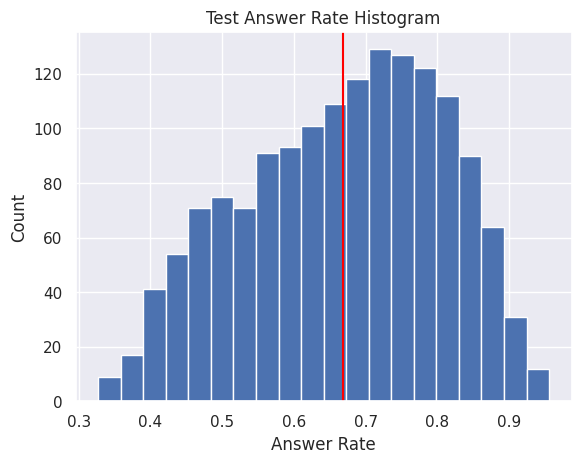

In [ ]:
fig, ax = plt.subplots()
test_groupby['answerCode'].hist(bins=20)
ax.set_title('Test Answer Rate Histogram')
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Count')
ax.axvline(test_groupby['answerCode'].mean(), color='red')
# ax.grid(b=True)

# 유형 별 정답률 분석

In [ ]:
know_groupby = df.groupby('KnowledgeTag').agg({
    'userID': 'count',
    # 'assessmentItemID': 'count',
    # 'testId': 'count',
    'answerCode': percentile
})
know_groupby.describe()

,userID,answerCode
count,912.000000,912.000000
mean,2485.291667,0.615524
std,1732.086925,0.148329
min,44.000000,0.188940
25%,1025.250000,0.498239
50%,2204.000000,0.599585
75%,4052.750000,0.740288
max,12892.000000,0.977778


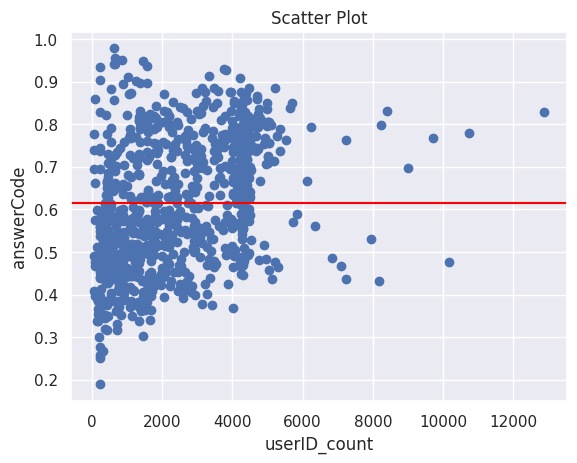

In [ ]:
plt.scatter(know_groupby['userID'], know_groupby['answerCode'])
plt.axhline(know_groupby['answerCode'].mean(), color='red')
plt.xlabel('userID_count')
plt.ylabel('answerCode')
plt.title('Scatter Plot')
plt.show()

## KnowledgeTag 유형별 확인

In [ ]:
# KnowledgeTag 고유값 추출
know_uni = df.KnowledgeTag.unique()

In [ ]:
# KnowledgeTag 고유값 중에 testcode 여러개 있는 KnowledgeTag 추출
not_know = []
for i in know_uni:
    if len(df[df['KnowledgeTag'] == i].testcode.unique()) != 1:
        not_know.append(i)

In [ ]:
# 오직 7863만 testcode 2개
not_know

[7863]

In [ ]:
df[df['KnowledgeTag'] == 7863].testcode.unique()

array(['080', '070'], dtype=object)

In [ ]:
df[df['KnowledgeTag'] == 7863]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed,testcode
230,0,A080037007,A080000037,0,2020-06-03 16:12:57,7863,3.0,080
5893,9,A070150003,A070000150,1,2020-12-11 20:16:41,7863,42.0,070
5894,9,A070150004,A070000150,1,2020-12-11 20:17:23,7863,171.0,070
5901,9,A070152003,A070000152,1,2020-12-14 20:44:46,7863,154.0,070
5911,9,A070154005,A070000154,1,2020-12-18 19:13:03,7863,9.0,070
...,...,...,...,...,...,...,...,...
2262727,7213,A070152003,A070000152,0,2020-12-24 03:44:16,7863,1.0,070
2262904,7223,A070151007,A070000151,1,2020-12-02 22:45:21,7863,2.0,070
2265424,7360,A070149003,A070000149,0,2020-12-24 06:17:39,7863,2.0,070
2265425,7360,A070149004,A070000149,0,2020-12-24 06:17:41,7863,2.0,070


오직 7863 유형만이 testcode의 중복을 가짐

testcode는 난이도가 아니다!

## 유저별 testcode 확인

In [ ]:
user_uni = df.userID.unique()

In [ ]:
dup_testcode_user = []
max_dup_user = 0
for i in user_uni:
    if len(df[df['userID'] == i].testcode.unique()) > 1:
        max_dup_user = max(max_dup_user, len(df[df['userID'] == i].testcode.unique()))
        dup_testcode_user.append(i)

In [ ]:
len(dup_testcode_user), max_dup_user

(6596, 3)

In [ ]:
df[df['userID'] == dup_testcode_user[0]].testcode.unique()

array(['060', '080', '020'], dtype=object)

In [ ]:
dup_testcode = []
for i in user_uni:
    if list(df[df['userID'] == i].testcode.unique()) not in dup_testcode:
        dup_testcode.append(list(df[df['userID'] == i].testcode.unique()))

In [ ]:
len(dup_testcode)

561

In [ ]:
df[df['userID'] == 0].testcode.unique()

array(['060', '080', '020'], dtype=object)

In [ ]:
from collections import Counter

# Counter를 사용하여 중복된 리스트 제거
unique_list = [list(k) for k, _ in Counter(map(tuple, map(sorted, dup_testcode))).items()]

len(unique_list)

129

In [ ]:
for i in range(1,8):
    for j in range(i+1, 9):
        for k in range(j+1, 10):
            if ['0{}0'.format(i), '0{}0'.format(j), '0{}0'.format(k)] not in unique_list:
                print(i, j, k)

유저들은 최대 3번의 모든 경우의 수로 testcode를 경험했다.

In [ ]:
def tag_map(x: int) -> int:
    x = int(x)
    x = x // 100
    return x

In [ ]:
def level_num(x: str) -> int:
    x = x[1]
    return int(x)

In [ ]:
df['level'] = df['level'].apply(level_num)

In [ ]:
df['KnowledgeTag_cat'] = df['KnowledgeTag'].apply(tag_map)

In [ ]:
df['testcode'] = df['level']

In [ ]:
tag_lv_groupby = df.groupby(['KnowledgeTag_cat', 'testcode'])['answerCode'].apply(percentile)
# yticks = [2, 1, 4, 6, 3, 7, 5, 9, 8]
# yticks = [8, 9, 5, 7, 3, 6, 4, 1, 2]
# ytick_labels = ['080', '090', '050', '070', '030', '060', '040', '010', '020']

g = sns.scatterplot(
    data=tag_lv_groupby,
    x='KnowledgeTag_cat',
    y='testcode',
    s = tag_lv_groupby.apply(point_size)
)
ax = plt.gca()
# plt.yticks(yticks, ytick_labels)
ax.set_title('Tag # - testcode #')

In [ ]:
tag_lv_groupby = df.groupby(['KnowledgeTag', 'testcode'])['answerCode'].apply(percentile)
# yticks = [2, 1, 4, 6, 3, 7, 5, 9, 8]
# yticks = [8, 9, 5, 7, 3, 6, 4, 1, 2]
# ytick_labels = ['080', '090', '050', '070', '030', '060', '040', '010', '020']

g = sns.scatterplot(
    data=tag_lv_groupby,
    x='KnowledgeTag',
    y='testcode',
    s = tag_lv_groupby.apply(point_size),
    alpha = 0.1
)
ax = plt.gca()
# plt.yticks(yticks, ytick_labels)
ax.set_title('Tag # - testcode #')

In [ ]:
tag_lv_groupby

In [ ]:
size_range = [2, 200]

In [ ]:
def point_size(scaled_accuracy):
    return size_range[0] + (size_range[1] - size_range[0]) * scaled_accuracy

In [ ]:
pp_size = tag_lv_groupby.apply(point_size)

In [ ]:
tag_lv_groupby.sort_index()

# 월과 testCode 관계

In [56]:
df['testCode'] = df['testId'].apply(lambda x : x[1:4])

#testCode 1~9의 정수형 값으로 변환
df['testCode'] = df['testCode'].astype('int') //10

In [57]:
df['month'] = df['Timestamp'].dt.month

In [ ]:
df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed,testCode,month
0,0,A060001001,A060000001,1,2020-03-24 09:17:11+09:00,7224,3.0,6,3
1,0,A060001002,A060000001,1,2020-03-24 09:17:14+09:00,7225,8.0,6,3
2,0,A060001003,A060000001,1,2020-03-24 09:17:22+09:00,7225,7.0,6,3
3,0,A060001004,A060000001,1,2020-03-24 09:17:29+09:00,7225,7.0,6,3
4,0,A060001005,A060000001,1,2020-03-24 09:17:36+09:00,7225,11.0,6,3
...,...,...,...,...,...,...,...,...,...
259365,7439,A040197006,A040000197,1,2020-08-21 16:39:45+09:00,2132,4721258.0,4,8
259366,7439,A040130001,A040000130,0,2020-10-15 08:07:23+09:00,8832,18.0,4,10
259367,7439,A040130002,A040000130,1,2020-10-15 08:07:41+09:00,8832,21.0,4,10
259368,7439,A040130003,A040000130,1,2020-10-15 08:08:02+09:00,8244,89.0,4,10


In [ ]:
month_groupby_2 = df.groupby(['month', 'testCode']).agg({'assessmentItemID':'count', 'answerCode':'mean'})

In [ ]:
month_groupby_2 = month_groupby_2.reset_index()
month_groupby_2

,month,testCode,assessmentItemID,answerCode
0,1,1,3637,0.847952
1,1,2,4411,0.772161
2,1,3,6347,0.730739
3,1,4,7024,0.655752
4,1,5,8440,0.667536
...,...,...,...,...
91,11,8,38418,0.502967
92,11,9,7419,0.474188
93,12,7,39405,0.506027
94,12,8,26964,0.506824


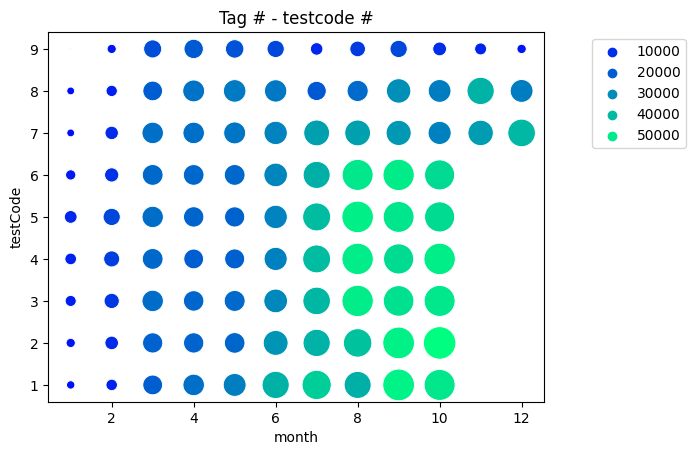

In [ ]:
# 점의 크기 범위 설정
size_range = (10, 20)

# 점의 크기를 정확도 값에 비례하여 계산
point_size = size_range[0] + (size_range[1] - size_range[0]) * month_groupby_2['assessmentItemID']

g = sns.scatterplot(
    data=month_groupby_2,
    x='month',
    y='testCode',
    s = month_groupby_2['assessmentItemID']*0.01,
    hue = month_groupby_2['assessmentItemID'],
    palette = 'winter',
    legend = 'brief'
)
ax = plt.gca()
ax.set_title('Tag # - testcode #')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1))

In [39]:
df_month = df.copy()
df_month['month'] = df_month['Timestamp'].dt.month

In [40]:
month_groupby = df_month.groupby(['month', 'testCode']).agg({'assessmentItemID':'count', 'answerCode':'mean'}).reset_index()

In [41]:
total = df_month.groupby('month').assessmentItemID.count().to_dict()
month_groupby['percentage'] = month_groupby['assessmentItemID'] / month_groupby['month'].map(total)

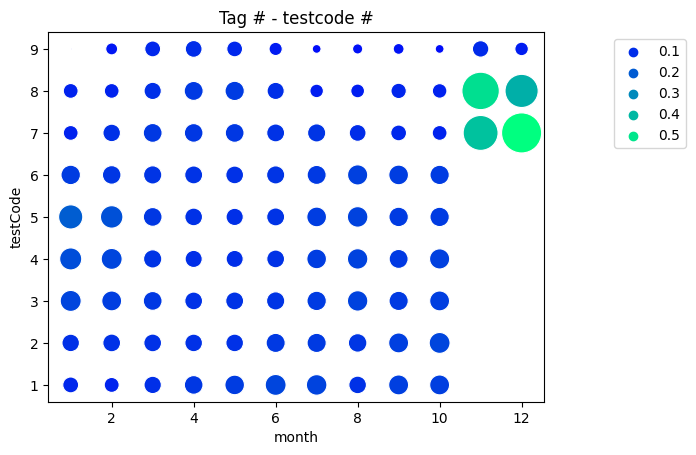

In [50]:
g = sns.scatterplot(
    data=month_groupby,
    x='month',
    y='testCode',
    s = month_groupby['percentage']*1500,
    hue = month_groupby['percentage'],
    palette = 'winter',
    legend = 'brief'
)
ax = plt.gca()
ax.set_title('Tag # - testcode #')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1))

In [51]:
month_groupby_1_10 = month_groupby[(month_groupby['month']!=11) & (month_groupby['month']!=12)]

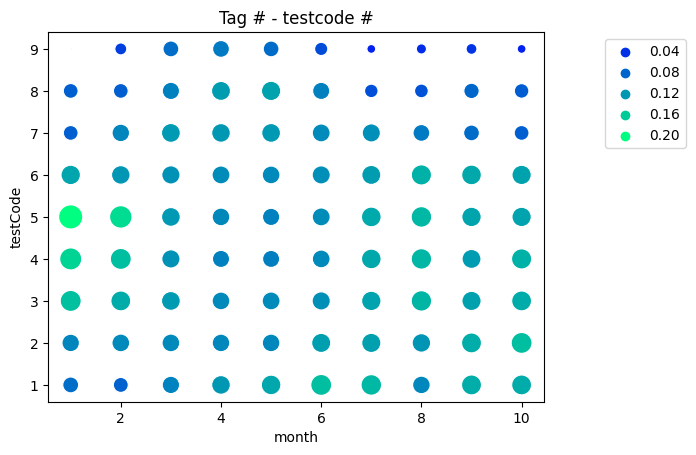

In [52]:
g = sns.scatterplot(
    data=month_groupby_1_10,
    x='month',
    y='testCode',
    s = month_groupby_1_10['percentage']*1500,
    hue = month_groupby_1_10['percentage'],
    palette = 'winter',
    legend = 'brief'
)
ax = plt.gca()
ax.set_title('Tag # - testcode #')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1))

## 월과 Tag 관계

In [58]:
month_groupby = df.groupby(['month', 'KnowledgeTag']).agg({'assessmentItemID':'count', 'answerCode':'mean'})

In [59]:
month_groupby = month_groupby.reset_index()

In [60]:
# KnowledgeTag를 천의 자리수를 기준으로 bining

month_groupby['label'] = month_groupby.KnowledgeTag.apply(lambda x: x//1000)

In [61]:
# 각 KnowledgeTag가 각 월에서 차지하는 비율을 계산

total_count = month_groupby.groupby('month').agg({'assessmentItemID':'sum'}).to_dict()
month_groupby['percentage'] = month_groupby['assessmentItemID'] / month_groupby.month.map(total_count['assessmentItemID'])

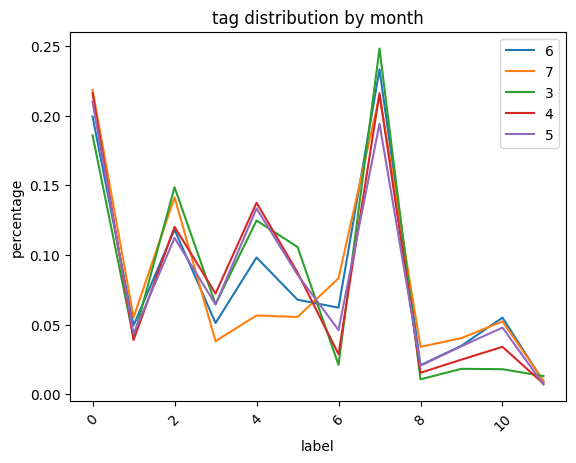

In [25]:
fig, ax = plt.subplots()

ax.set_title("tag distribution by month")
sns.lineplot(data=month_groupby[month_groupby['month'] == 6],
            x="label", y='percentage', ci=None, estimator=sum, label='6')
sns.lineplot(data=month_groupby[month_groupby['month'] == 7],
            x="label", y='percentage', ci=None, estimator=sum, label='7')
ax.set_title("tag distribution by month")
sns.lineplot(data=month_groupby[month_groupby['month'] == 3],
            x="label", y='percentage', ci=None, estimator=sum, label='3')
sns.lineplot(data=month_groupby[month_groupby['month'] == 4],
            x="label", y='percentage', ci=None, estimator=sum, label='4')
sns.lineplot(data=month_groupby[month_groupby['month'] == 5],
            x="label", y='percentage', ci=None, estimator=sum, label='5')

plt.xticks(rotation=45)
plt.legend()

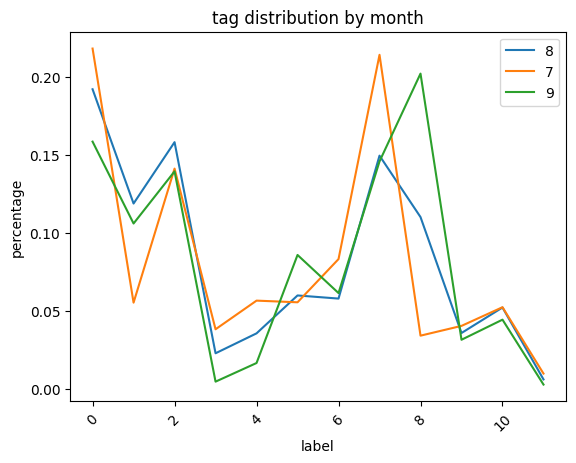

In [27]:
fig, ax = plt.subplots()

ax.set_title("tag distribution by month")
sns.lineplot(data=month_groupby[month_groupby['month'] == 8],
            x="label", y='percentage', ci=None, estimator=sum, label='8')
sns.lineplot(data=month_groupby[month_groupby['month'] == 7],
            x="label", y='percentage', ci=None, estimator=sum, label='7')
sns.lineplot(data=month_groupby[month_groupby['month'] == 9],
            x="label", y='percentage', ci=None, estimator=sum, label='9')

plt.xticks(rotation=45)
plt.legend()

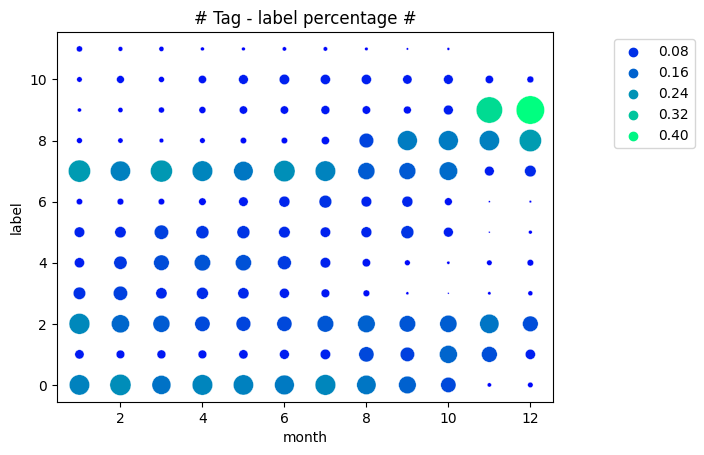

In [84]:
mon_lab_groupby = month_groupby.groupby(['month', 'label']).agg({'percentage':sum})

g = sns.scatterplot(
    data=mon_lab_groupby,
    x='month',
    y='label',
    s = mon_lab_groupby['percentage']*1000,
    hue = mon_lab_groupby['percentage'],
    palette = 'winter',
    legend = 'brief'
)
ax = plt.gca()
ax.set_title('# Tag - label percentage #')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1))